# Object Masking

## Load Datasets

In [1]:
import cv2
import datetime
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

In [5]:
images_path = '../data/datasets/vegetable_dog_dataset/images'
images = load_images_from_folder(images_path)
sample_size = 4
sequential = True
plot_dpi = 144

images_count = len(images)
if sequential:
    start = random.randint(0, images_count - sample_size)
    taken_images_index = [*range(start, start + sample_size)]
else:
    taken_images_index = random.sample(range(images_count), sample_size if images_count > sample_size else images_count)
print('Taken {} from {} images'.format(taken_images_index, images_count))

sample_images = [images[i] for i in taken_images_index]

Taken [17, 18, 19, 20] from 25 images


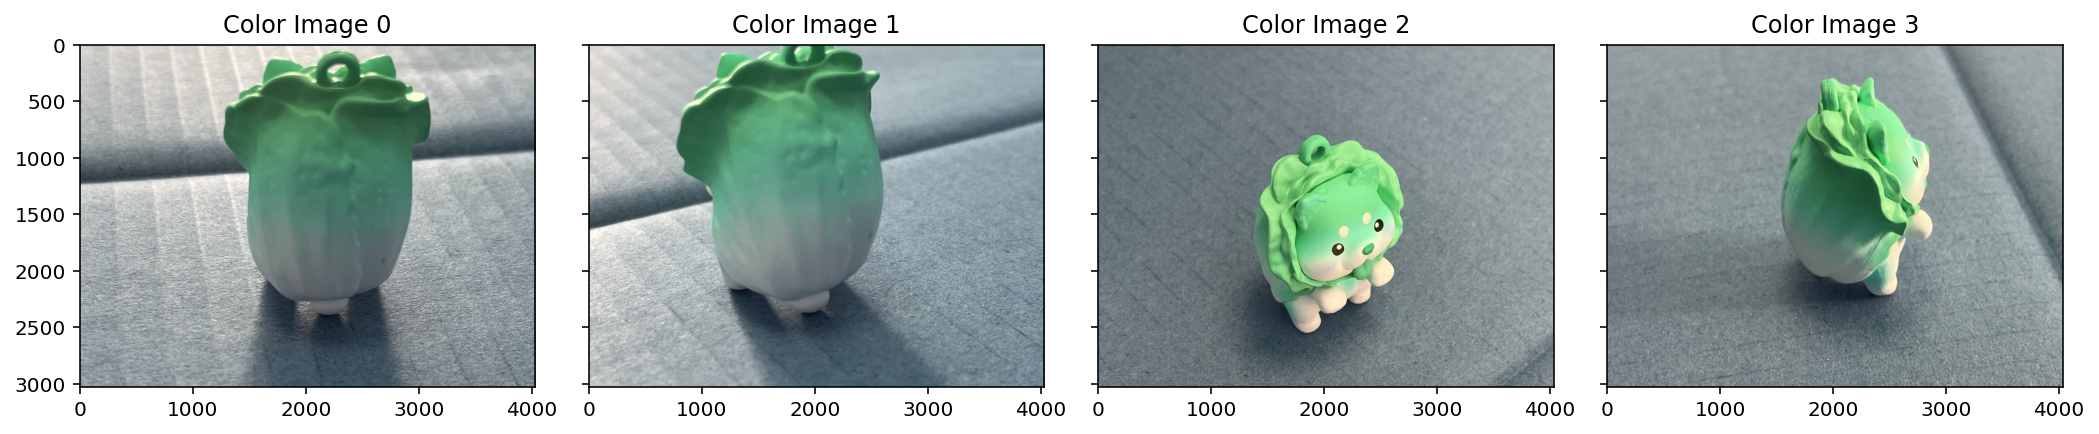

In [7]:
def display_samples(images):
    fig, ax = plt.subplots(1, len(images), figsize=(14.5, 6), constrained_layout=True, sharey=True)
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(len(images)):
        ax[i].set_title('Color Image {}'.format(i))
        ax[i].imshow(images[i])

display_samples(sample_images)

## Extract Objects by Masks

### DIS

In [8]:
import torch
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \'{}\''.format(device))

Running inference on device 'cpu'


In [9]:
from thirdparty.DIS.IS_Net.data_loader_cache import normalize, im_reader, im_preprocess 
from thirdparty.DIS.IS_Net.models.isnet import ISNetGTEncoder, ISNetDIS

hypar = {
    'model_path': '../data/models/is-net',  # load trained weights from this path
    'restore_model': 'isnet.pth',           # name of the to-be-loaded weights
    'interm_sup': False,                    # indicate if activate intermediate feature supervision
    'model_digit': 'full',                  # indicates 'half' or 'full' accuracy of float number
    'seed': 0,
    'cache_size': [1024, 1024],             # cached input spatial resolution, can be configured into different size
    'input_size': [1024, 1024],             # mdoel input spatial size, usually use the same value hypar['cache_size'], which means we don't further resize the images
    'crop_size': [1024, 1024],              # random crop size from the input, it is usually set as smaller than hypar['cache_size'], e.g., [920,920] for data augmentation
    'model': ISNetDIS()
}                                           # paramters for inferencing

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
# Normalize the Image using torch.transforms
class GOSNormalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = normalize(image, self.mean, self.std)
        return image

transform = transforms.Compose([GOSNormalize([0.5, 0.5, 0.5], [1.0, 1.0, 1.0])])

def normalize_2_tensor_with_size(im, hypar):
    im, im_shp = im_preprocess(im, hypar['cache_size'])
    im = torch.divide(im, 255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) 

normalized_sample_images = [normalize_2_tensor_with_size(im, hypar) for im in sample_images]

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [12]:
def build_model(hypar, device):
    net = hypar['model'] # GOSNETINC(3, 1)
    # convert to half precision
    if(hypar['model_digit'] == 'half'):
        net.half()
        for layer in net.modules():
            if isinstance(layer, torch.nn.BatchNorm2d):
                layer.float()
    net.to(device)
    if(hypar['restore_model'] != ''):
        net.load_state_dict(torch.load(hypar['model_path'] + '/' + hypar['restore_model'], map_location=device))
        net.to(device)
    net.eval() 
    return net

dis_net = build_model(hypar, device)
dis_net.eval()

ISNetDIS(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

In [17]:
def dis_predict_masks(images_tensor_with_size):
    predicted_masks = []
    time_ms = []

    for (inputs_val, shapes_val) in images_tensor_with_size:
        inputs_val = inputs_val.type(torch.FloatTensor if hypar['model_digit'] == 'full' else torch.HalfTensor)
        inputs_val_v = torch.autograd.Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable

        b = datetime.datetime.now()
        ds_val = dis_net(inputs_val_v)[0] # list of 6 results
        e = datetime.datetime.now()
        time_ms.append((e - b).microseconds / 1000)

        pred_val = ds_val[0][0, :, :, :] # B x 1 x H x W, we want the first one which is the most accurate prediction
        # recover the prediction spatial size to the orignal image size
        pred_val = torch.squeeze(torch.nn.functional.upsample(
            torch.unsqueeze(pred_val, 0), (shapes_val[0][0], shapes_val[0][1]),
            mode='bilinear')
        )
        ma = torch.max(pred_val)
        mi = torch.min(pred_val)
        pred_val = (pred_val - mi) / (ma - mi) # max = 1
        mask = (pred_val.detach().cpu().numpy() * 255).astype(np.uint8) # it is the mask we need
        predicted_masks.append(mask)
    
    return predicted_masks, time_ms

dis_predicted_masks, dis_time_ms = dis_predict_masks(normalized_sample_images)
print(dis_time_ms)

/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/unbinilium/Documents/Develop/Python/SfM/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[539.574, 168.549, 820.306, 84.615]


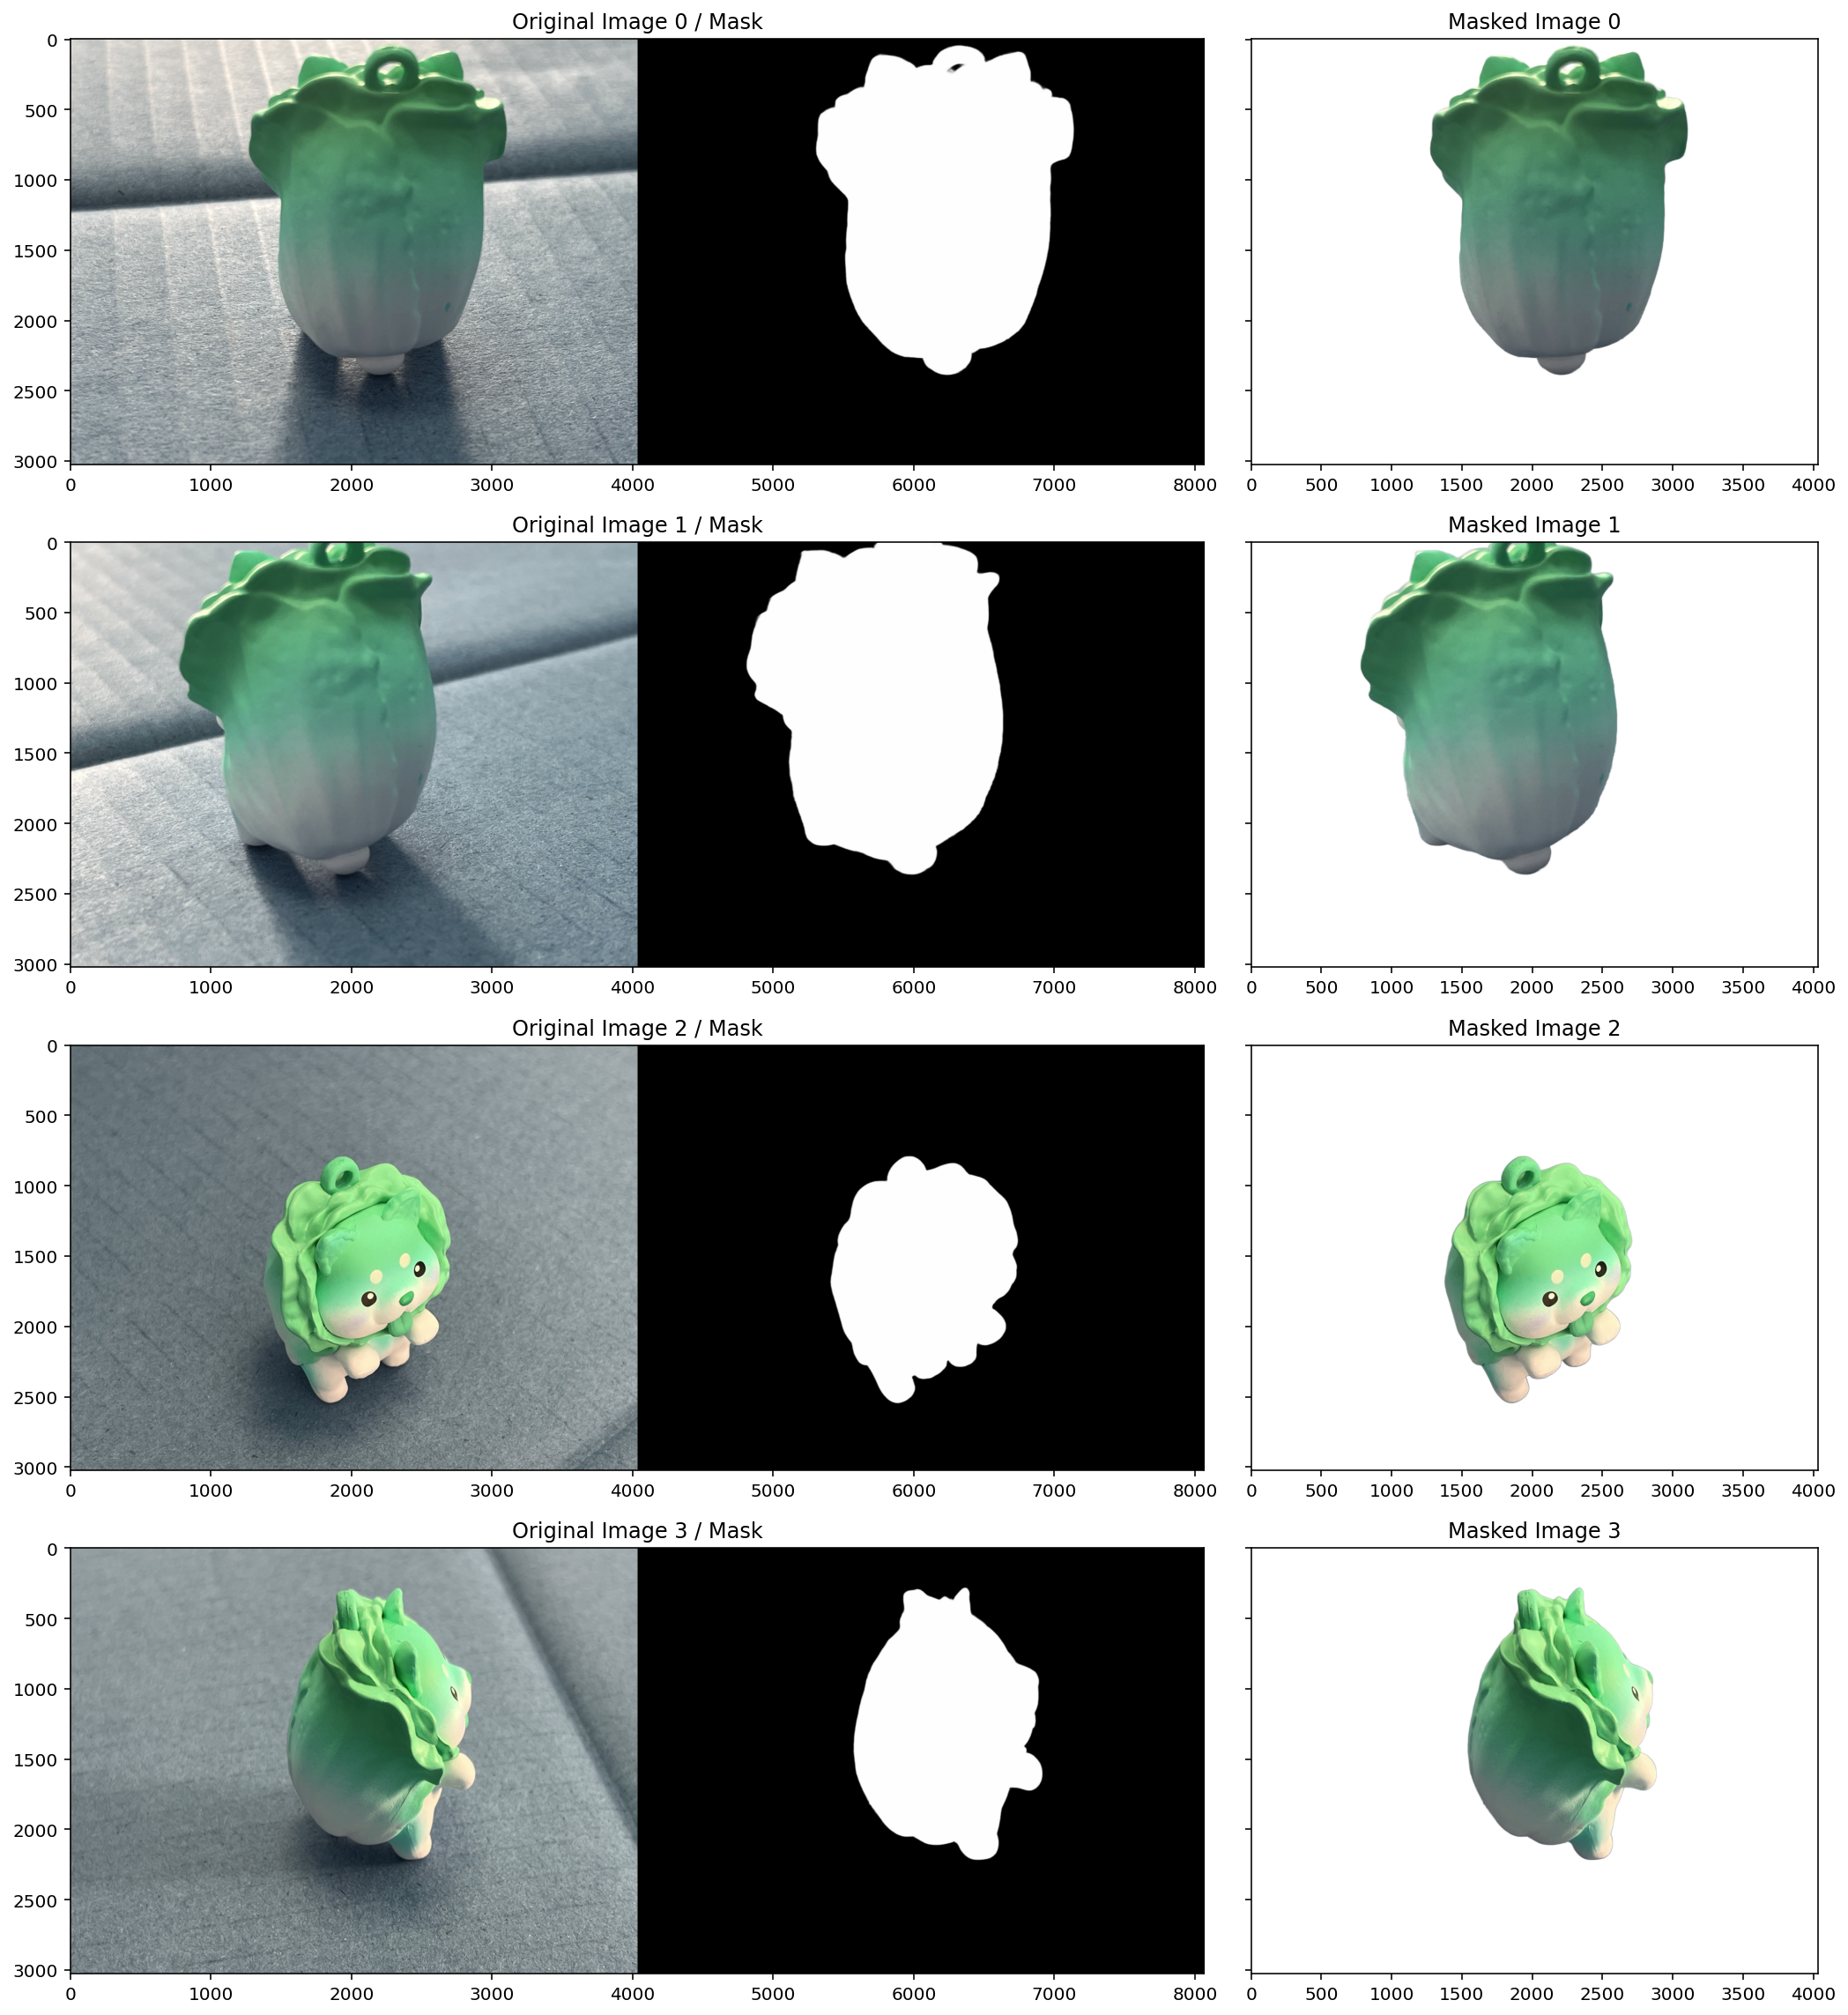

In [42]:
from PIL import Image

def display_mask_results(original_images, masks):
    fig, ax = plt.subplots(
        len(original_images), 2, figsize=(14.5, 4 * len(original_images)),
        gridspec_kw={'width_ratios': [2, 1]},
        constrained_layout=True, sharey=True
    )
    fig.set_dpi(plot_dpi)
    fig.tight_layout()

    for i in range(0, len(original_images)):
        mask_3 = cv2.cvtColor(masks[i], cv2.COLOR_GRAY2RGB)
        (h0, w0), (h1, w1) = original_images[i].shape[:2], mask_3.shape[:2]
        stitch_image = np.empty((max(h0, h1), w0 + w1, 3), dtype=np.uint8)
        stitch_image[:h0, :w0, :3] = original_images[i]
        stitch_image[:h1, w0:, :3] = mask_3
        pil_mask = Image.fromarray(mask_3).convert('L')
        pil_img = Image.fromarray(original_images[i])
        pil_img_rgba = pil_img.copy()
        pil_img_rgba.putalpha(pil_mask)
        
        ax[i, 0].set_title('Original Image {} / Mask'.format(i))
        ax[i, 0].imshow(stitch_image)
        ax[i, 1].set_title('Masked Image {}'.format(i))
        ax[i, 1].imshow(pil_img_rgba)
        
display_mask_results(sample_images, dis_predicted_masks)